<a href="https://colab.research.google.com/github/joaopamaral/tcc_puc_cdbd/blob/master/EDA_TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Exploratória dos dados - Desafio de Redução de Fatalidades na Aviação Comercial

## Importando bibliotecas necessárias

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os, math
from tqdm.auto import tqdm

IN_COLAB = 'google.colab' in sys.modules

%matplotlib inline
plt.style.use('ggplot')

In [0]:
# Removendo warning de depreciação do matlab utilizado no Seaborn
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [0]:
gdrive_kaggle_dir = '/gdrive/My Drive/Kaggle'
competition_name = 'reducing-commercial-aviation-fatalities'
api_gdrive_credential_location = f'{gdrive_kaggle_dir}/kaggle.json'
data_gdrive_dir = f'{gdrive_kaggle_dir}/{competition_name}'
api_local_credential_location = os.path.join(os.path.expanduser('~'), '.kaggle/kaggle.json')

In [27]:
# Montando google drive caso esteja executando no google colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Obtendo os dados do desafio

In [0]:
def get_kaggle_json(api_location):
    api_local_credential_location = os.path.join(os.path.expanduser('~'), '.kaggle/kaggle.json')
    !mkdir -p ~/.kaggle
    !cp '{api_location}' '{api_local_credential_location}'

def get_kaggle_data_competition(competition_name, gdrive_kaggle_dir=None):
    IN_COLAB = 'google.colab' in sys.modules

    if IN_COLAB and not os.path.exists(competition_name):
        gdrive_competition_path = os.path.join(gdrive_kaggle_dir, competition_name)
        if os.path.exists(gdrive_competition_path):
            !cp -r '{gdrive_competition_path}' .

    if not os.path.exists(competition_name):
        # Instalação do pacote para acesso a API do Kaggle
        !pip -q install kaggle --upgrade
        # Download dos dados da competição
        !kaggle competitions download -c {competition_name} -p {competition_name}
        if IN_COLAB and os.path.exists(gdrive_kaggle_dir):
            !cp -r {competition_name} '{gdrive_kaggle_dir}'

In [0]:
get_kaggle_json(api_gdrive_credential_location)
get_kaggle_data_competition('reducing-commercial-aviation-fatalities', gdrive_kaggle_dir)

### Realizando a leitura dos dados para um DataFrame

In [0]:
raw_train_df = pd.read_csv(f'{competition_name}/train.csv.zip', dtype={'crew': 'category', 'experiment': 'category', 'seat': 'category', 'event': 'category'})

Visualizando uma amostra dos dados

In [31]:
raw_train_df.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,23.712299,-6.695870,29.232100,24.842899,3.92134,18.447001,1.07547,3.09029,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,21.010300,-6.474720,26.641399,24.138800,5.46991,20.510599,2.83354,7.10177,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,25.431801,-0.088707,28.119900,26.891300,8.57886,23.162901,4.51993,12.70550,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,19.142799,-0.256516,30.653601,24.247000,8.64310,19.961901,7.27575,11.45980,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,20.572100,-1.953470,31.722601,25.155500,12.50030,18.746901,7.30976,8.00805,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


## Iniciando análise de estatística descritiva

In [32]:
# A mudança na opção de visualização foi apenas para evitar notações cientificas na tabela de descrição
pd.set_option('display.float_format', lambda x: f'{x:.5f}' if np.isnan(x) or abs(x - int(x)) > 1e-6 else f'{x:.0f}')
display(raw_train_df.describe(include='all'))
pd.reset_option('display.float_format')

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
count,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421,4867421
unique,9,3,nan,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4
top,6,DA,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,A
freq,552958,1658393,nan,2433939,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2848809
mean,NaN,NaN,178.23584,NaN,3.74634,1.36000,1.21364,0.07351,0.07845,0.08675,0.22999,3.62728,0.18365,0.26506,0.44072,1.38539,1.31627,1.20860,0.60500,0.24140,0.19476,0.62437,0.44291,0.23937,5285.46006,737.60898,851.84670,NaN
std,NaN,NaN,103.95916,NaN,45.06763,35.18923,35.19242,24.31472,18.03932,18.32606,25.31132,46.15674,28.07377,16.58195,64.10874,42.84167,54.81694,42.05516,20.52105,16.60196,18.33801,19.75695,19.74815,23.51859,12141.26381,81.87979,503.93239,NaN
min,NaN,NaN,0.00300,NaN,-1361.35999,-1581.32996,-1643.94995,-1516.64001,-1220.51001,-1266.43005,-1279.93994,-1393.47998,-2887.90991,-1226.78003,-2875.93994,-1353.41003,-4064.07007,-2333.83008,-1212.03003,-1228.03003,-1229.13000,-1230.47998,-696.27899,-1176.37000,-18585.69922,482.06000,0,NaN
25%,NaN,NaN,88.08100,NaN,-9.20025,-8.32515,-8.76761,-7.36724,-6.10200,-6.00726,-6.90403,-9.57500,-6.65734,-6.58046,-7.64364,-9.28555,-8.05544,-9.30643,-7.49597,-6.71386,-6.77484,-7.16116,-7.81765,-6.52695,-2550.07007,663.14301,524.11401,NaN
50%,NaN,NaN,176.92969,NaN,0.38190,0.04264,0.11404,0,0,0,0,0.38934,0,0,0,0.11708,0.11067,0.05668,0,0,0,0,0,0,5920.50977,743.43799,770.19702,NaN
75%,NaN,NaN,268.33984,NaN,10.30610,8.75334,9.28256,7.43778,6.17663,6.08646,7.07146,10.62990,6.78108,6.74435,7.81001,9.95549,8.63161,9.77577,7.76567,6.83132,6.90502,7.46652,8.02519,6.61518,10290.09961,813.41199,1197.12000,NaN


Verificação dos tipos inferidos para cada campo após a leitura

In [33]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867421 entries, 0 to 4867420
Data columns (total 28 columns):
crew          category
experiment    category
time          float64
seat          category
eeg_fp1       float64
eeg_f7        float64
eeg_f8        float64
eeg_t4        float64
eeg_t6        float64
eeg_t5        float64
eeg_t3        float64
eeg_fp2       float64
eeg_o1        float64
eeg_p3        float64
eeg_pz        float64
eeg_f3        float64
eeg_fz        float64
eeg_f4        float64
eeg_c4        float64
eeg_p4        float64
eeg_poz       float64
eeg_c3        float64
eeg_cz        float64
eeg_o2        float64
ecg           float64
r             float64
gsr           float64
event         category
dtypes: category(4), float64(24)
memory usage: 909.8 MB


Verificando a existencia de dados faltantes em cada coluna

In [34]:
raw_train_df.isna().sum()

crew          0
experiment    0
time          0
seat          0
eeg_fp1       0
eeg_f7        0
eeg_f8        0
eeg_t4        0
eeg_t6        0
eeg_t5        0
eeg_t3        0
eeg_fp2       0
eeg_o1        0
eeg_p3        0
eeg_pz        0
eeg_f3        0
eeg_fz        0
eeg_f4        0
eeg_c4        0
eeg_p4        0
eeg_poz       0
eeg_c3        0
eeg_cz        0
eeg_o2        0
ecg           0
r             0
gsr           0
event         0
dtype: int64

Definindo índices únicos para os dados e armazenando em um novo dataframe para tratamento

In [0]:
train_df = raw_train_df.set_index(['crew', 'experiment', 'seat', 'time'])

In [36]:
# Verificando existência de dados duplicados
print(f'Total de Dados Duplicados: {train_df.duplicated().sum()}')
print(f'Total de índices Duplicados: {train_df.index.duplicated().sum()}')

Total de Dados Duplicados: 755
Total de índices Duplicados: 0


### Gerando report com estatística básica

> Atenção, como a quantidade de dados é relativamente grande, a geração do report sem o flag indicando `minimal=True` (para não realizar análises de correlação) pode fazer o relatório ficar em geração por horas.

In [0]:
import pandas_profiling as pp

# pp.ProfileReport(train_df).to_file('/gdrive/My Drive/Kaggle/eda_reducing-commercial-aviation-fatalities_complete.html')
# Report Minimo
# pp.ProfileReport(train_df, minimal=True).to_file('/gdrive/My Drive/Kaggle/eda_reducing-commercial-aviation-fatalities_minimal.html')

### Verificando distribuição dos dados em relação a variáveis categóricas

#### Distribuição considerando uma variável

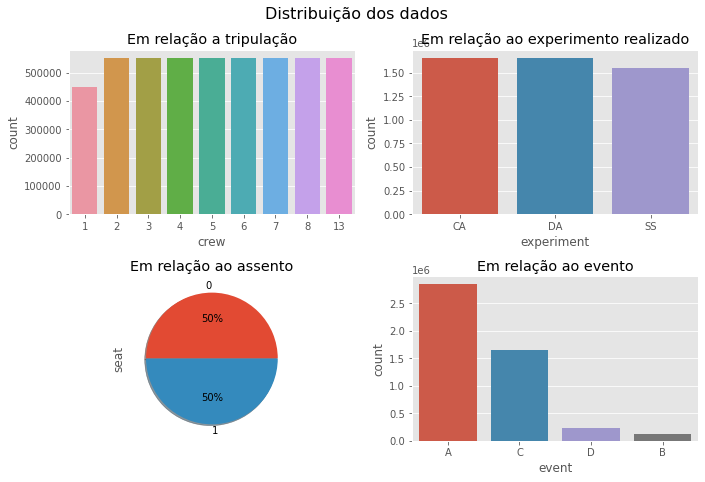

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(10,7))

sns.countplot(train_df.index.get_level_values('crew'), ax=ax[0][0]).set_title('Em relação a tripulação');
sns.countplot(train_df.index.get_level_values('experiment'), ax=ax[0][1]).set_title('Em relação ao experimento realizado');
train_df.index.get_level_values('seat').value_counts().plot.pie(autopct='%.0f%%', shadow=True, ax=ax[1][0]).set_title('Em relação ao assento');
sns.countplot(train_df.event, ax=ax[1][1]).set_title('Em relação ao evento');

fig.suptitle('Distribuição dos dados', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustes dos graficos para não sobrepor os labels e titulo

> A partir da distribuição podemos ver um primeiro problema a ser enfrentado, a distrbuição dos dados em relação ao Evento. Isso indica que teremos um problema de **classes desbalanceadas** e será necessário realizar algum tratamento para evitar maiores impactos no modelo a ser desenvolvido.

#### Distribuição considerando duas variáveis

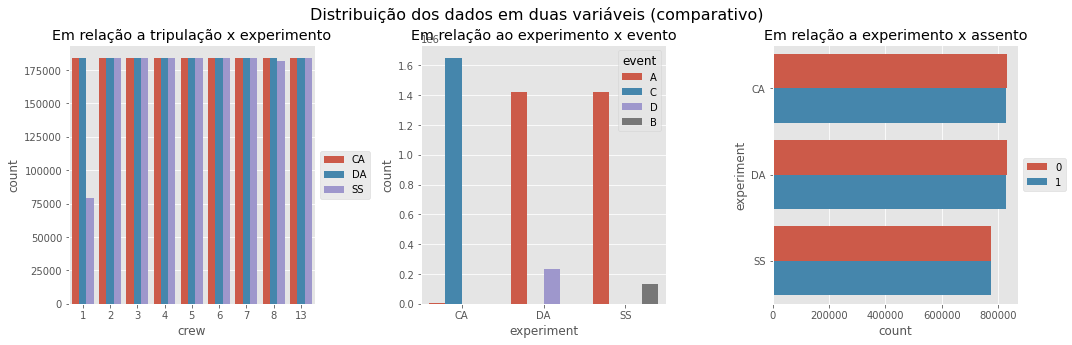

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

sns.countplot(x="crew", hue="experiment", data=train_df.reset_index(), ax=ax[0]).set_title('Em relação a tripulação x experimento');
sns.countplot(x="experiment", hue="event", data=train_df.reset_index(), ax=ax[1]).set_title('Em relação ao experimento x evento');
sns.countplot(y="experiment", hue="seat", data=train_df.reset_index(), ax=ax[2]).set_title('Em relação a experimento x assento');

for i in [0, 2]:
    ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle('Distribuição dos dados em duas variáveis (comparativo)', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustes dos graficos para não sobrepor os labels e titulo

> O interessante que podemos destacar nessa análise é a relação do evento com o experimento. Como esperado, o evento de atenção canalizada (CA) foi todo realizado gerando apenas um evento C, ou seja, o piloto foi forçado a manter a concetração em uma atividade durante todo o experimento. Os experimentos de atenção divergente e de susto, acionaram os eventos D (outra atividade durante o experimento) e B (evento de susto) somente em alguns momentos do experimento, no restante do experimento tivemos o evento A (atenção básica). Isso justifica o porque temos esse desbalanceamento de classes no problema.

### Visualização do comportamento dos dados no tempo

In [0]:
# Separando as variáveis em grupos para facilitar as analises
eeg_columns = ['eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', 
               'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3', 
               'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4',	'eeg_c4', 
               'eeg_p4', 'eeg_poz', 'eeg_c3', 'eeg_cz', 'eeg_o2']

numeric_features = [*eeg_columns, 'ecg', 'r', 'gsr']
categorical_feature = ['event']

#### Eletroencefalograma

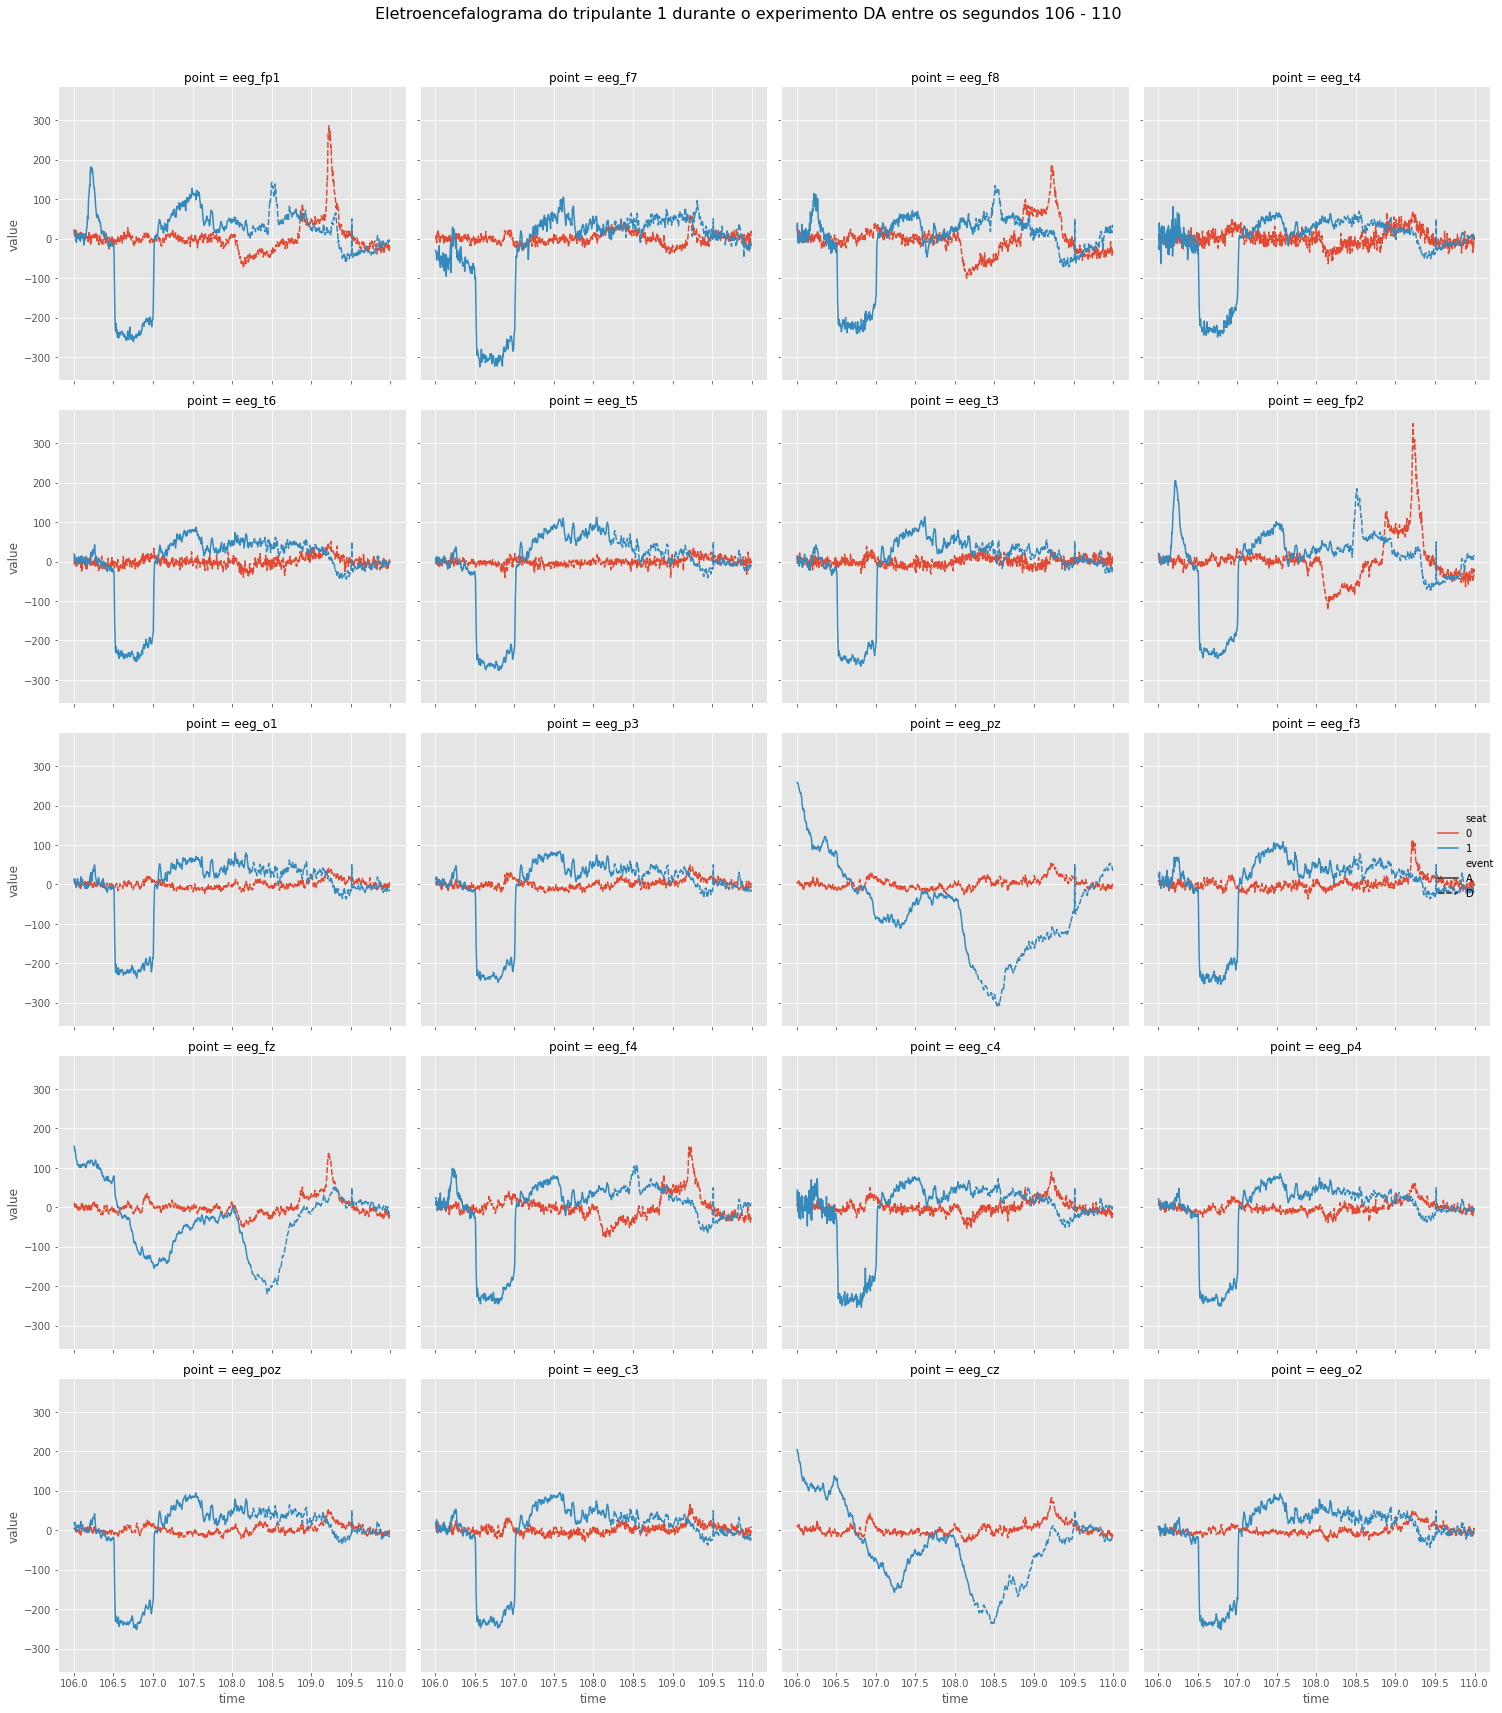

In [41]:
def plot_eeg(crew='1', experiment='DA', start_time=106, end_time=110):
    g = sns.relplot(x="time", y='value', col="point", kind='line', col_wrap=4, hue='seat', style='event',
                data=train_df.reset_index().query(f'crew == "{crew}" & experiment == "{experiment}" & time > {start_time} & time < {end_time}')
                .loc[:, ['time', 'event', 'seat', *eeg_columns]].set_index(['time', 'event', 'seat'])
                .stack().reset_index().rename(columns={'level_3': 'point', 0: 'value'}))
    g.fig.suptitle(f'Eletroencefalograma do tripulante {crew} durante o experimento {experiment} entre os segundos {start_time} - {end_time}', fontsize=16);
    g.fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
plot_eeg()

#### Eletrocardiograma, Respiração e Resposta Galvânica da Pele

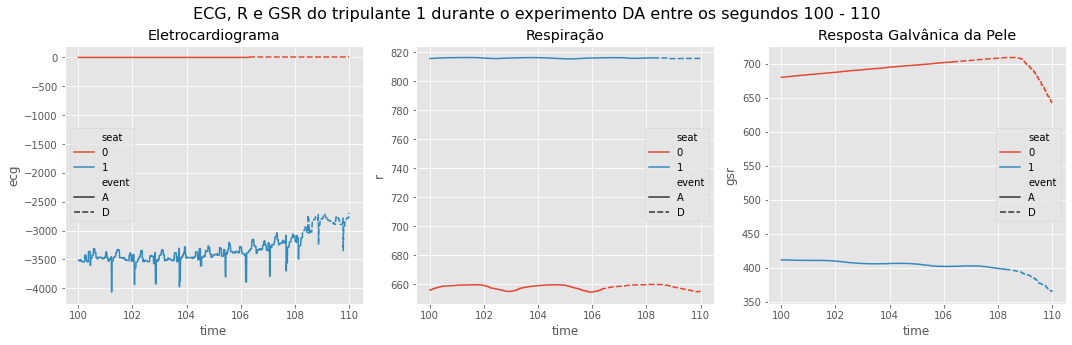

In [42]:
def plot_ecg_r_gsr(crew='1', experiment='DA', start_time=100, end_time=110):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))

    filtered_data = train_df.reset_index().query(f'crew == "{crew}" & experiment == "{experiment}" & time > {start_time} & time < {end_time}')

    sns.lineplot(x="time", y="ecg", hue='seat', style='event', data=filtered_data, ax=ax[0]).set_title('Eletrocardiograma');
    sns.lineplot(x="time", y="r", hue='seat', style='event', data=filtered_data, ax=ax[1]).set_title('Respiração');
    sns.lineplot(x="time", y="gsr", hue='seat', style='event', data=filtered_data, ax=ax[2]).set_title('Resposta Galvânica da Pele');

    fig.suptitle(f'ECG, R e GSR do tripulante {crew} durante o experimento {experiment} entre os segundos {start_time} - {end_time}', fontsize=16);
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
plot_ecg_r_gsr()

> Nessa análise podemos ver que durante esse experimento, o piloto no assento 0 ficou com o eletrocardiograma zerado, como podemos afirmar que o piloto não teve uma parada cardíaca durante o experimento, a única justificativa plausível foi que existe um erro de medição nesse caso. Será necessário tratar esses erros nos dados.


> Outra análise interessante é o aumento do ECG e a redução da Resposta Galvânica da pele quando o piloto passa do evento A para o D. Isso pode demonstrar uma correlação interessante entre essas variáveis e a variável objetivo, o evento.

Dados zerado por 10 segundos: 93961.0


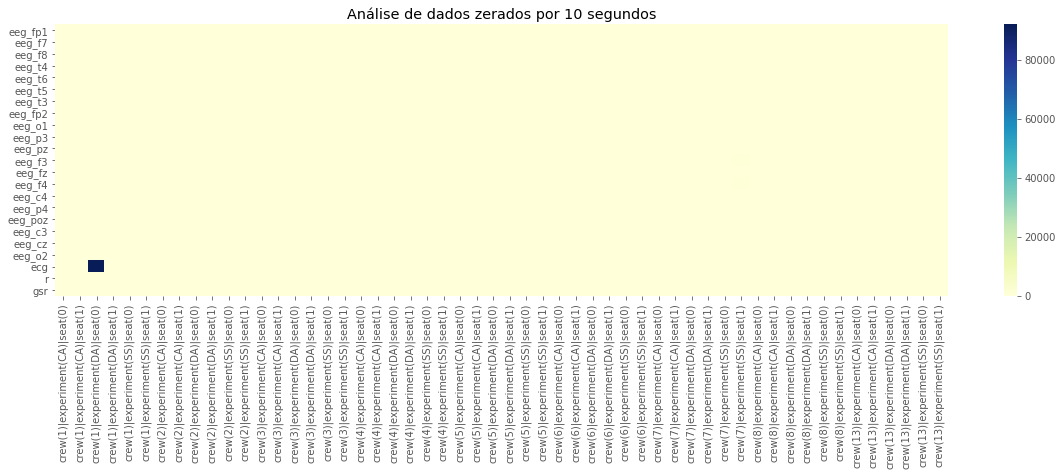

In [43]:
map_zero_entry_df = (train_df.sort_index().rolling(10).mean() == 0).groupby(level=['crew', 'experiment', 'seat']).sum().T
print(f'Dados zerado por 10 segundos: {map_zero_entry_df.sum().sum()}')
map_zero_entry_df.columns = map_zero_entry_df.columns.map(lambda x: f'crew({x[0]})|experiment({x[1]})|seat({x[2]})')

plt.figure(figsize=(20, 5))
sns.heatmap(map_zero_entry_df, cmap="YlGnBu").set_title('Análise de dados zerados por 10 segundos');

### Verificando distribuição dos dados em relação a variáveis numéricas

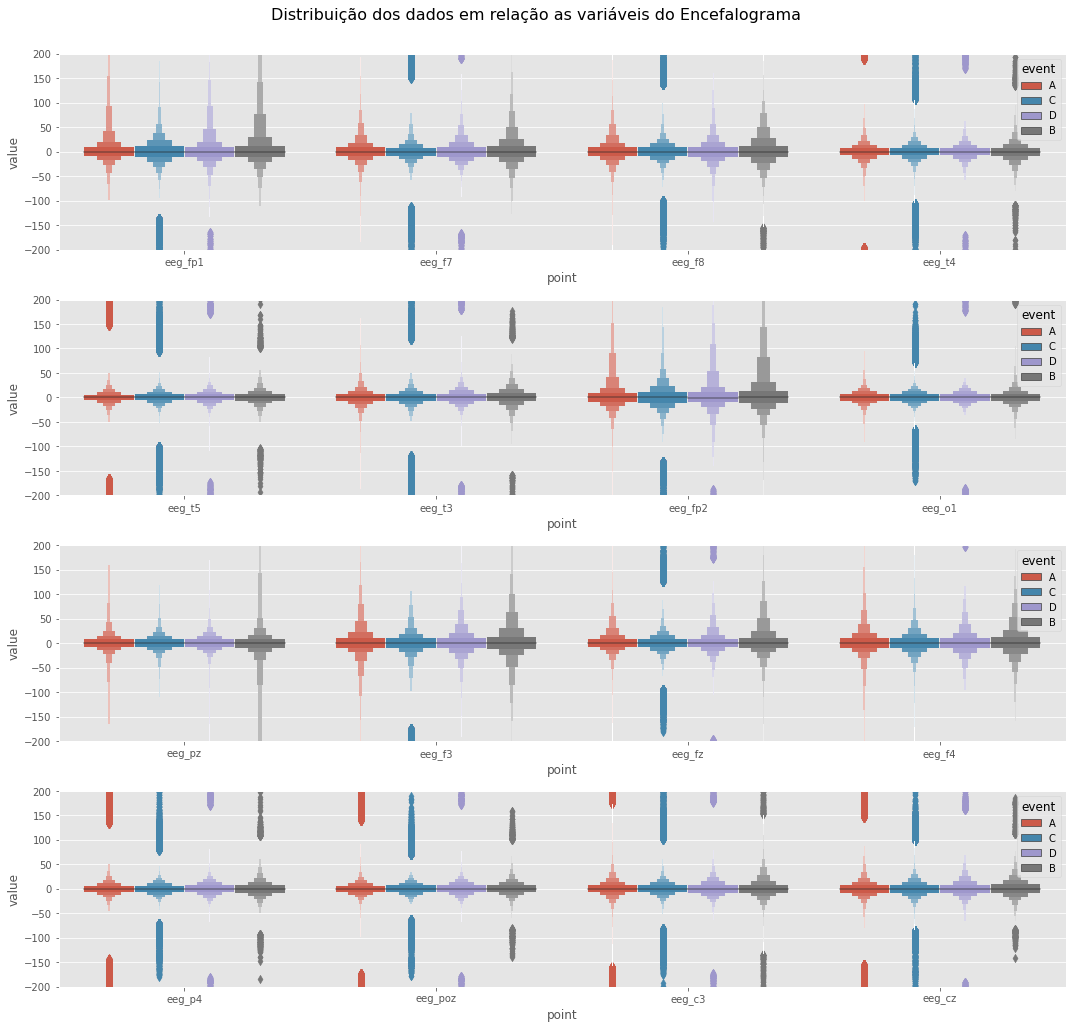

In [44]:
def plot_boxen_eeg():
    fig, ax = plt.subplots(4, 1, figsize=(15,15))

    df = train_df.reset_index().loc[:, ['time', 'event', 'seat', *eeg_columns]].set_index(['time', 'event', 'seat'])\
                    .stack().reset_index().rename(columns={'level_3': 'point', 0: 'value'})

    for i, ix in enumerate(range(0, len(eeg_columns), 5)):
        ax[i].set_ylim(-200, 200)
        sns.boxenplot(x="point", y="value", hue="event", ax=ax[i], data=df[df.point.isin(np.array(eeg_columns)[range(ix, ix + 4)])])

    fig.suptitle(f'Distribuição dos dados em relação as variáveis do Encefalograma', fontsize=16);
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plot_boxen_eeg()

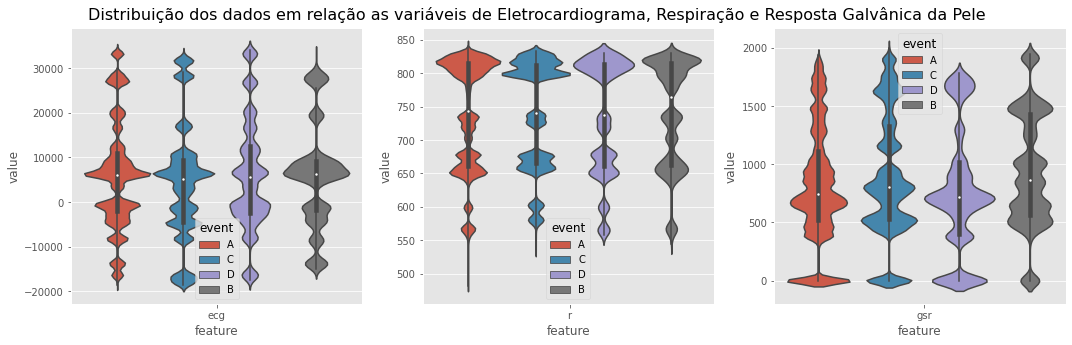

In [45]:
def plot_violin_ecg_r_gsr():
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    features = ['ecg', 'r', 'gsr']
    
    df = train_df.reset_index().loc[:, ['event', *features]].set_index('event')\
                    .stack().reset_index().rename(columns={'level_1': 'feature', 0: 'value'})

    for i, feature in enumerate(features):
        sns.violinplot(x="feature", y="value", hue="event", data=df[df.feature == feature], ax=ax[i])

    fig.suptitle(f'Distribuição dos dados em relação as variáveis de Eletrocardiograma, Respiração e Resposta Galvânica da Pele', fontsize=16);
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plot_violin_ecg_r_gsr()

### Análise de Correlação entre as variáveis

In [0]:
g = sns.pairplot(train_df.sample(10000), hue="event");
g.fig.suptitle(f'Análise de correlação entre variáveis', fontsize=16);
g.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [0]:
corr_df = train_df[numeric_features].corr()

In [0]:
plt.figure(figsize=(15,10))
sns.heatmap(corr_df, vmin=-1, vmax=1, center= 0);

In [0]:
corr_table = corr_df.abs().apply(lambda x: (corr_df.columns.get_loc(x.name) < x.index.map(corr_df.index.get_loc)) * x).unstack()
corr_table = corr_table.loc[corr_table > 0]
corr_table = pd.cut(corr_table, bins=[0, .3, .5, .7, .9, 1], labels=["Desprezível", "Fraca", "Moderada", 'Forte', 'Muito Forte']).sort_values(ascending=False)

sns.countplot(corr_table);

In [0]:
pd.DataFrame(corr_table[corr_table >= 'Moderada'], columns=['Correlação'])

# Limpeza Final dos dados de treinamento

In [0]:
# Removendo dados duplicados
final_df = train_df.drop_duplicates()
print(f'Total de Dados Duplicados: {final_df.duplicated().sum()}')

In [0]:
# Removendo dados de sensores com 10 medições zeradas
final_df = final_df.drop((final_df.sort_index().rolling(10).mean() == 0))
print(f'Total de até 10 medições consecutivas zeradas : {final_df.duplicated().sum()}')